## Statistical modeling with Julia

## Before you start

In this tutorial we will use the following statistical concepts:

* [confidence intervals](https://en.wikipedia.org/wiki/Confidence_interval)
* [density estimators](https://en.wikipedia.org/wiki/Density_estimation)
* [probit model](https://en.wikipedia.org/wiki/Probit_model)
* [bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics))

If you want to follow the material smoothly it is recommended that you review them before continuing.

Load the packages we will use:

In [1]:
using Bootstrap
using CSV
using CategoricalArrays
using Chain
using DataFrames
using GLM
using Plots
using Random
using StatsPlots
using Statistics

## Data preprocessing

We will work with the classic *participation.csv* data.

The description of the data set can be found here: https://vincentarelbundock.github.io/Rdatasets/doc/Ecdat/Participation.html.

In [2]:
readlines("participation.csv")

873-element Vector{String}:
 "\"\",\"lfp\",\"lnnlinc\",\"age\",\"educ\",\"nyc\",\"noc\",\"foreign\""
 "\"1\",\"no\",10.787497,3,8,1,1,\"no\""
 "\"2\",\"yes\",10.524251,4.5,8,0,1,\"no\""
 "\"3\",\"no\",10.968578,4.6,9,0,0,\"no\""
 "\"4\",\"no\",11.104999,3.1,11,2,0,\"no\""
 "\"5\",\"no\",11.10847,4.4,12,0,2,\"no\""
 "\"6\",\"yes\",11.028254,4.2,12,0,1,\"no\""
 "\"7\",\"no\",11.454707,5.1,8,0,0,\"no\""
 "\"8\",\"yes\",10.490918,3.2,8,0,2,\"no\""
 "\"9\",\"no\",10.62474,3.9,12,0,0,\"no\""
 "\"10\",\"no\",10.48642,4.3,11,0,2,\"no\""
 "\"11\",\"no\",10.660618,4.5,11,0,2,\"no\""
 "\"12\",\"no\",10.467589,6,12,0,0,\"no\""
 ⋮
 "\"861\",\"yes\",10.528899,3.4,9,1,1,\"yes\""
 "\"862\",\"yes\",10.468534,3.3,6,0,2,\"yes\""
 "\"863\",\"no\",11.110955,3.5,10,1,1,\"yes\""
 "\"864\",\"no\",10.471365,5.1,9,0,1,\"yes\""
 "\"865\",\"no\",10.147503,4.1,5,1,0,\"yes\""
 "\"866\",\"yes\",10.69323,3.5,9,0,2,\"yes\""
 "\"867\",\"yes\",10.027595,4.2,14,0,0,\"yes\""
 "\"868\",\"no\",10.597393,2.4,4,2,1,\"yes\""
 

Our objective is to build a model predicting the `"lfp"` variable (labor force participation).

First read in the data into a data frame:

In [3]:
df_raw = CSV.read("participation.csv", DataFrame)

Row,Column1,lfp,lnnlinc,age,educ,nyc,noc,foreign
,Int64,String3,Float64,Float64,Int64,Int64,Int64,String3
1,1,no,10.7875,3.0,8,1,1,no
2,2,yes,10.5243,4.5,8,0,1,no
3,3,no,10.9686,4.6,9,0,0,no
4,4,no,11.105,3.1,11,2,0,no
5,5,no,11.1085,4.4,12,0,2,no
6,6,yes,11.0283,4.2,12,0,1,no
7,7,no,11.4547,5.1,8,0,0,no
8,8,yes,10.4909,3.2,8,0,2,no
9,9,no,10.6247,3.9,12,0,0,no


Inspect the contents of the data set to make sure it got loaded correctly:

In [4]:
describe(df_raw)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,Column1,436.5,1,436.5,872,0,Int64
2,lfp,,no,,yes,0,String3
3,lnnlinc,10.6856,7.1869,10.6431,12.3757,0,Float64
4,age,3.99553,2.0,3.9,6.2,0,Float64
5,educ,9.30734,1,9.0,21,0,Int64
6,nyc,0.311927,0,0.0,3,0,Int64
7,noc,0.982798,0,1.0,6,0,Int64
8,foreign,,no,,yes,0,String3


Now transform the data set. We use the `select` function and perform the following transformations:
* recode `"lfp"` variable from text to binary;
* add square of `"age"` column;
* change `"foreign"` column to be categorical;
* all other columns are left as they are.

The general syntax of column transformation options is:
```
source columns => transformation => target columns name
```
(the `transformation` and `target columns name` can be dropped)

Also note the `ByRow` wrapper which tells `select` to perform the operation row-wise (by default operations are performed on whole columns).

In [this post](https://bkamins.github.io/julialang/2020/12/24/minilanguage.html) you can find an explanation of the most typical cases of supported transformation specifications.

In [5]:
df = select(df_raw,
            "lfp" => (x -> recode(x, "yes" => 1, "no" => 0)) => "lfp",
            "lnnlinc",
            "age",
            "age" => ByRow(x -> x^2) => "age²",
            Between("educ", "noc"),
            "foreign" => categorical => "foreign")

Row,lfp,lnnlinc,age,age²,educ,nyc,noc,foreign
,Int64,Float64,Float64,Float64,Int64,Int64,Int64,Cat…
1,0,10.7875,3.0,9.0,8,1,1,no
2,1,10.5243,4.5,20.25,8,0,1,no
3,0,10.9686,4.6,21.16,9,0,0,no
4,0,11.105,3.1,9.61,11,2,0,no
5,0,11.1085,4.4,19.36,12,0,2,no
6,1,11.0283,4.2,17.64,12,0,1,no
7,0,11.4547,5.1,26.01,8,0,0,no
8,1,10.4909,3.2,10.24,8,0,2,no
9,0,10.6247,3.9,15.21,12,0,0,no


If we want to leave column names unchanged we can use `renamecols=false` keyword argument, and in this case the target column name can be dropped:

In [6]:
df = select(df_raw,
            "lfp" => (x -> recode(x, "yes" => 1, "no" => 0)),
            "lnnlinc",
            "age",
            "age" => ByRow(x -> x^2) => "age²",
            Between("educ", "noc"),
            "foreign" => categorical,
            renamecols=false)

Row,lfp,lnnlinc,age,age²,educ,nyc,noc,foreign
,Int64,Float64,Float64,Float64,Int64,Int64,Int64,Cat…
1,0,10.7875,3.0,9.0,8,1,1,no
2,1,10.5243,4.5,20.25,8,0,1,no
3,0,10.9686,4.6,21.16,9,0,0,no
4,0,11.105,3.1,9.61,11,2,0,no
5,0,11.1085,4.4,19.36,12,0,2,no
6,1,11.0283,4.2,17.64,12,0,1,no
7,0,11.4547,5.1,26.01,8,0,0,no
8,1,10.4909,3.2,10.24,8,0,2,no
9,0,10.6247,3.9,15.21,12,0,0,no


Check the summary statistics of the updated table:

In [7]:
describe(df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,lfp,0.459862,0,0.0,1,0,Int64
2,lnnlinc,10.6856,7.1869,10.6431,12.3757,0,Float64
3,age,3.99553,2.0,3.9,6.2,0,Float64
4,age²,17.0763,4.0,15.21,38.44,0,Float64
5,educ,9.30734,1,9.0,21,0,Int64
6,nyc,0.311927,0,0.0,3,0,Int64
7,noc,0.982798,0,1.0,6,0,Int64
8,foreign,,no,,yes,0,"CategoricalValue{String3, UInt32}"


## Exploratory data analysis

We want to compute the mean of numeric columns by `:lfp` to initialy check in what direction they influence the target.

In the example we use the following:
* the `@chain` macro from the [Chain.jl](https://github.com/jkrumbiegel/Chain.jl) package; it allows for convenient piping of operations;
* the `groupby` function that adds the key column to the data frame (groups the data frame by the passed column)
* the `combine` function that combines the rows of a data frame by some function

In [8]:
@chain df begin
    groupby("lfp")
    combine(["lnnlinc", "age", "educ", "nyc", "noc"] .=> mean)
end

Row,lfp,lnnlinc_mean,age_mean,educ_mean,nyc_mean,noc_mean
,Int64,Float64,Float64,Float64,Float64,Float64
1,0,10.7513,4.08535,9.59448,0.409766,0.902335
2,1,10.6083,3.89002,8.97007,0.197007,1.07731


Observe that the following:

In [9]:
["lnnlinc", "age", "educ", "nyc", "noc"] .=> mean

5-element Vector{Pair{String, typeof(mean)}}:
 "lnnlinc" => Statistics.mean
     "age" => Statistics.mean
    "educ" => Statistics.mean
     "nyc" => Statistics.mean
     "noc" => Statistics.mean

is a convenient way to specify multiple similar transformations using the broadcasting syntax provided by Julia.

You can find more examples of this pattern at work [here](https://bkamins.github.io/julialang/2021/07/09/multicol.html).

If we did not want to list all the columns manually we could have written (note that `"lfp"` was included as it is binary):

In [10]:
@chain df begin
    groupby("lfp")
    combine(names(df, Real) .=> mean)
end

Row,lfp,lfp_mean,lnnlinc_mean,age_mean,age²_mean,educ_mean,nyc_mean,noc_mean
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0,0.0,10.7513,4.08535,18.0357,9.59448,0.409766,0.902335
2,1,1.0,10.6083,3.89002,15.9496,8.97007,0.197007,1.07731


Now handle the categorical variable `:foreign`.

Note that this time we pass just `nrow` to combine, which has a special treatement and returns the number of rows in each group.

In [11]:
@chain df begin
    groupby(["lfp", "foreign"])
    combine(nrow)
end

Row,lfp,foreign,nrow
,Int64,Cat…,Int64
1,0,no,402
2,0,yes,69
3,1,no,254
4,1,yes,147


If we wanted to create a cross-tabulation of the data we can put:
* the `"lfp"` variable as rows,
* the `"foreign"` variable as columns,
* the `"nrow"` variable as values,

using the `unstack` function.

More advanced examples of reshaping of data frames are presented [here](https://bkamins.github.io/julialang/2021/05/28/pivot.html).

In [12]:
@chain df begin
    groupby(["lfp", "foreign"])
    combine(nrow)
    unstack("lfp", "foreign", "nrow")
end

Row,lfp,no,yes
,Int64,Int64?,Int64?
1,0,402,69
2,1,254,147


or just:

In [13]:
unstack(df, "lfp", "foreign", "foreign", combine=length)

Row,lfp,no,yes
,Int64,Int64?,Int64?
1,0,402,69
2,1,254,147


Finally let us add another step to our `@chain`, which will create a fraction of `"yes"` answers in each group.

Note that in this example we show how to pass more than one column to a transformation function.

In [14]:
@chain df begin
    groupby(["lfp", "foreign"])
    combine(nrow)
    unstack("lfp", "foreign", "nrow")
    select("lfp", ["no", "yes"] => ByRow((x, y) -> y / (x + y)) => "foreign_yes")
end

Row,lfp,foreign_yes
,Int64,Float64
1,0,0.146497
2,1,0.366584


An observant reader will notice that we could have done it in one step like this (the benefit of being verbose was that we have learned more features of DataFrames.jl):

In [15]:
@chain df begin
    groupby("lfp")
    combine("foreign" => (x -> mean(x .== "yes")) => "foreign_yes")
end

Row,lfp,foreign_yes
,Int64,Float64
1,0,0.146497
2,1,0.366584


The `GroupedDataFrame` that is created by the `groupby` function can be a useful object to work with on its own.

In [16]:
gd = groupby(df, "lfp")

Row,lfp,lnnlinc,age,age²,educ,nyc,noc,foreign
,Int64,Float64,Float64,Float64,Int64,Int64,Int64,Cat…
1,0,10.7875,3.0,9.0,8,1,1,no
2,0,10.9686,4.6,21.16,9,0,0,no
3,0,11.105,3.1,9.61,11,2,0,no
4,0,11.1085,4.4,19.36,12,0,2,no
5,0,11.4547,5.1,26.01,8,0,0,no
6,0,10.6247,3.9,15.21,12,0,0,no
7,0,10.4864,4.3,18.49,11,0,2,no
8,0,10.6606,4.5,20.25,11,0,2,no
9,0,10.4676,6.0,36.0,12,0,0,no


Note that you can conveniently index into it to get the groups.

First we use the standard indexing syntax:

In [17]:
gd[1]

Row,lfp,lnnlinc,age,age²,educ,nyc,noc,foreign
,Int64,Float64,Float64,Float64,Int64,Int64,Int64,Cat…
1,0,10.7875,3.0,9.0,8,1,1,no
2,0,10.9686,4.6,21.16,9,0,0,no
3,0,11.105,3.1,9.61,11,2,0,no
4,0,11.1085,4.4,19.36,12,0,2,no
5,0,11.4547,5.1,26.01,8,0,0,no
6,0,10.6247,3.9,15.21,12,0,0,no
7,0,10.4864,4.3,18.49,11,0,2,no
8,0,10.6606,4.5,20.25,11,0,2,no
9,0,10.4676,6.0,36.0,12,0,0,no


Now we we use a special indexing syntax that efficiently selects groups by their value (not position):

In [18]:
gd[(lfp=0,)]

Row,lfp,lnnlinc,age,age²,educ,nyc,noc,foreign
,Int64,Float64,Float64,Float64,Int64,Int64,Int64,Cat…
1,0,10.7875,3.0,9.0,8,1,1,no
2,0,10.9686,4.6,21.16,9,0,0,no
3,0,11.105,3.1,9.61,11,2,0,no
4,0,11.1085,4.4,19.36,12,0,2,no
5,0,11.4547,5.1,26.01,8,0,0,no
6,0,10.6247,3.9,15.21,12,0,0,no
7,0,10.4864,4.3,18.49,11,0,2,no
8,0,10.6606,4.5,20.25,11,0,2,no
9,0,10.4676,6.0,36.0,12,0,0,no


In [19]:
gd[Dict("lfp" => 0)]

Row,lfp,lnnlinc,age,age²,educ,nyc,noc,foreign
,Int64,Float64,Float64,Float64,Int64,Int64,Int64,Cat…
1,0,10.7875,3.0,9.0,8,1,1,no
2,0,10.9686,4.6,21.16,9,0,0,no
3,0,11.105,3.1,9.61,11,2,0,no
4,0,11.1085,4.4,19.36,12,0,2,no
5,0,11.4547,5.1,26.01,8,0,0,no
6,0,10.6247,3.9,15.21,12,0,0,no
7,0,10.4864,4.3,18.49,11,0,2,no
8,0,10.6606,4.5,20.25,11,0,2,no
9,0,10.4676,6.0,36.0,12,0,0,no


In [20]:
gd[(0,)]

Row,lfp,lnnlinc,age,age²,educ,nyc,noc,foreign
,Int64,Float64,Float64,Float64,Int64,Int64,Int64,Cat…
1,0,10.7875,3.0,9.0,8,1,1,no
2,0,10.9686,4.6,21.16,9,0,0,no
3,0,11.105,3.1,9.61,11,2,0,no
4,0,11.1085,4.4,19.36,12,0,2,no
5,0,11.4547,5.1,26.01,8,0,0,no
6,0,10.6247,3.9,15.21,12,0,0,no
7,0,10.4864,4.3,18.49,11,0,2,no
8,0,10.6606,4.5,20.25,11,0,2,no
9,0,10.4676,6.0,36.0,12,0,0,no


Before we move forward let us investigate why we have added a square of `"age"` to our data frame.

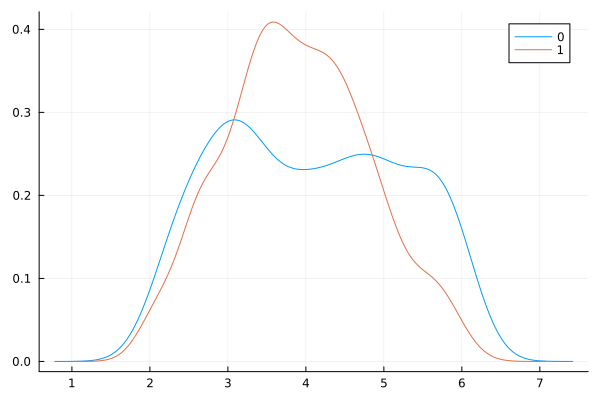

In [21]:
density(df.age, group=df.lfp)

## Building a predictive model

Now we are ready to create the probit model using the [GLM.jl](https://github.com/JuliaStats/GLM.jl) package:

In [22]:
probit = glm(@formula(lfp ~ lnnlinc + age + age² + educ + nyc + noc + foreign),
             df, Binomial(), ProbitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, ProbitLink}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

lfp ~ 1 + lnnlinc + age + age² + educ + nyc + noc + foreign

Coefficients:
────────────────────────────────────────────────────────────────────────────
                   Coef.  Std. Error      z  Pr(>|z|)  Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)    3.74896     1.40663     2.67    0.0077   0.992006   6.50591
lnnlinc       -0.666932    0.13192    -5.06    <1e-06  -0.92549   -0.408374
age            2.07531     0.405407    5.12    <1e-06   1.28073    2.86989
age²          -0.294345    0.0499446  -5.89    <1e-08  -0.392235  -0.196456
educ           0.0191963   0.0179255   1.07    0.2842  -0.015937   0.0543295
nyc           -0.714465    0.100397   -7.12    <1e-11  -0.911238  -0.517691
noc

In the example above we have entered the `@formula` by hand. However, it can be also programmatically generated like this:

In [23]:
probit = glm(Term(:lfp) ~ sum(Term.(propertynames(df)[2:end])),
             df, Binomial(), ProbitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, ProbitLink}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

lfp ~ 1 + lnnlinc + age + age² + educ + nyc + noc + foreign

Coefficients:
────────────────────────────────────────────────────────────────────────────
                   Coef.  Std. Error      z  Pr(>|z|)  Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)    3.74896     1.40663     2.67    0.0077   0.992006   6.50591
lnnlinc       -0.666932    0.13192    -5.06    <1e-06  -0.92549   -0.408374
age            2.07531     0.405407    5.12    <1e-06   1.28073    2.86989
age²          -0.294345    0.0499446  -5.89    <1e-08  -0.392235  -0.196456
educ           0.0191963   0.0179255   1.07    0.2842  -0.015937   0.0543295
nyc           -0.714465    0.100397   -7.12    <1e-11  -0.911238  -0.517691
noc

Note the following:

In [24]:
Term(:lfp) ~ sum(Term.(propertynames(df)[2:end]))

FormulaTerm
Response:
  lfp(unknown)
Predictors:
  lnnlinc(unknown)
  age(unknown)
  age²(unknown)
  educ(unknown)
  nyc(unknown)
  noc(unknown)
  foreign(unknown)

vs.

In [25]:
@formula(lfp ~ lnnlinc + age + age² + educ + nyc + noc + foreign)

FormulaTerm
Response:
  lfp(unknown)
Predictors:
  lnnlinc(unknown)
  age(unknown)
  age²(unknown)
  educ(unknown)
  nyc(unknown)
  noc(unknown)
  foreign(unknown)

Also note that all "standard" variable names can be written as e.g. `"age"` or `:age` in DataFrames.jl.
This is not the case in all packages.

Recall that we coudl automatically do the computation of the square of `:age`:

In [26]:
probit = glm(@formula(lfp ~ lnnlinc + age + age^2 + educ + nyc + noc + foreign),
             df, Binomial(), ProbitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, ProbitLink}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

lfp ~ 1 + lnnlinc + age + :(age ^ 2) + educ + nyc + noc + foreign

Coefficients:
────────────────────────────────────────────────────────────────────────────
                   Coef.  Std. Error      z  Pr(>|z|)  Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)    3.74896     1.40663     2.67    0.0077   0.992006   6.50591
lnnlinc       -0.666932    0.13192    -5.06    <1e-06  -0.92549   -0.408374
age            2.07531     0.405407    5.12    <1e-06   1.28073    2.86989
age ^ 2       -0.294345    0.0499446  -5.89    <1e-08  -0.392235  -0.196456
educ           0.0191963   0.0179255   1.07    0.2842  -0.015937   0.0543295
nyc           -0.714465    0.100397   -7.12    <1e-11  -0.911238  -0.5176

We check the formula again:

In [27]:
@formula(lfp ~ lnnlinc + age + age^2 + educ + nyc + noc + foreign)

FormulaTerm
Response:
  lfp(unknown)
Predictors:
  lnnlinc(unknown)
  age(unknown)
  (age)->age ^ 2
  educ(unknown)
  nyc(unknown)
  noc(unknown)
  foreign(unknown)

Next we prepare a new data frame in which we will check how the prediction of our model changes as we modify `:age` while keeping all other variables constant:

In [28]:
df_pred = DataFrame(lnnlinc=10.0, age= 2.0:0.1:6.2, educ = 9, nyc = 0, noc = 1, foreign = "yes")

Row,lnnlinc,age,educ,nyc,noc,foreign
,Float64,Float64,Int64,Int64,Int64,String
1,10.0,2.0,9,0,1,yes
2,10.0,2.1,9,0,1,yes
3,10.0,2.2,9,0,1,yes
4,10.0,2.3,9,0,1,yes
5,10.0,2.4,9,0,1,yes
6,10.0,2.5,9,0,1,yes
7,10.0,2.6,9,0,1,yes
8,10.0,2.7,9,0,1,yes
9,10.0,2.8,9,0,1,yes


We make a prediction along with its confidence interval:

In [29]:
probit_pred = predict(probit, df_pred, interval=:confidence)

Row,prediction,lower,upper
,Float64?,Float64?,Float64?
1,0.786122,0.636712,0.891844
2,0.81054,0.679167,0.902237
3,0.831686,0.716389,0.91142
4,0.849882,0.748559,0.919526
5,0.865445,0.776012,0.926671
6,0.878681,0.799173,0.932954
7,0.889869,0.818506,0.93846
8,0.899262,0.834474,0.943258
9,0.907082,0.847512,0.947403


Now we plot it. Note that we use `Matrix` constructor to create a matrix out of the data frame easily:

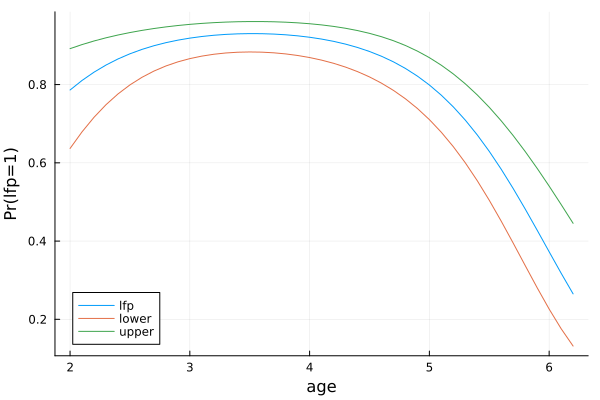

In [30]:
plot(df_pred.age, Matrix(probit_pred), labels=["lfp" "lower" "upper"],
     xlabel="age", ylabel="Pr(lfp=1)")

## Advanced DataFrames.jl functionalities: bootstrapping example

Let us investigate the `probit` object again:

In [31]:
probit

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, ProbitLink}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

lfp ~ 1 + lnnlinc + age + :(age ^ 2) + educ + nyc + noc + foreign

Coefficients:
────────────────────────────────────────────────────────────────────────────
                   Coef.  Std. Error      z  Pr(>|z|)  Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)    3.74896     1.40663     2.67    0.0077   0.992006   6.50591
lnnlinc       -0.666932    0.13192    -5.06    <1e-06  -0.92549   -0.408374
age            2.07531     0.405407    5.12    <1e-06   1.28073    2.86989
age ^ 2       -0.294345    0.0499446  -5.89    <1e-08  -0.392235  -0.196456
educ           0.0191963   0.0179255   1.07    0.2842  -0.015937   0.0543295
nyc           -0.714465    0.100397   -7.12    <1e-11  -0.911238  -0.5176

We can see that we obtained parametric confidence intervals for the parameters. However, our sample was not very big, so we want to verify them using bootstrapping.

First we will do bootstrapping by hand, and next we will compare the results with what the [Bootstrap.jl](https://github.com/juliangehring/Bootstrap.jl) package produces.

As usual we will try to learn some new features of DataFrames.jl along the way.

We start with a function that takes a data frame and:
1. creates one bootstrap sample of its contents
2. fits the probit model to the bootstrapped data
3. returns a `NamedTuple` with the computed coefficients

In [32]:
function boot_sample(df)
    df_boot = df[rand(1:nrow(df), nrow(df)), :]
    probit_boot = glm(@formula(lfp ~ lnnlinc + age + age^2 + educ + nyc + noc + foreign),
                      df_boot, Binomial(), ProbitLink())
    return (; (Symbol.(coefnames(probit_boot)) .=> coef(probit_boot))...)
end

boot_sample (generic function with 1 method)

Let us test it:

In [33]:
boot_sample(df)

(var"(Intercept)" = 3.048710276127432, lnnlinc = -0.6402300532260949, age = 2.2566273504605463, var"age ^ 2" = -0.3123292025731039, educ = 0.005954664637637262, nyc = -0.6489103122935688, noc = -0.18962360944003953, var"foreign: yes" = 0.9400269406747372)

We need to run the `boot_sample` function multiple times. Note that we store the results in the `coef_boot` data frame.

In [34]:
function run_boot(df, reps)
    coef_boot = DataFrame()
    for _ in 1:reps
        push!(coef_boot, boot_sample(df))
    end
    return coef_boot
end

run_boot (generic function with 1 method)

We seed the random number generator as we want comparable results to what Bootstrap.jl produces (I have made sure to sample rows for bootstrapping in the same way in our manual code).

In [35]:
Random.seed!(1234)
coef_boot = run_boot(df, 1000)

Row,(Intercept),lnnlinc,age,age ^ 2,educ,nyc,noc,foreign: yes
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,3.89753,-0.683644,2.19622,-0.315711,0.00184476,-0.759661,-0.116304,0.59132
2,6.03733,-0.808077,1.85422,-0.277391,0.00815517,-0.817424,-0.196143,0.556323
3,3.78851,-0.702459,2.09578,-0.289319,0.0274796,-0.560228,-0.131949,0.728109
4,3.84855,-0.673669,2.20824,-0.30794,-0.00995106,-0.817733,-0.199632,0.612467
5,3.86901,-0.677679,2.07178,-0.285416,0.00782889,-0.610081,-0.173919,0.607915
6,4.24138,-0.678265,2.28935,-0.338982,0.0034059,-0.926661,-0.350053,0.654847
7,3.76902,-0.64247,1.91971,-0.278204,0.0287484,-0.727808,-0.201696,0.868374
8,5.15023,-0.798031,1.90498,-0.26878,0.0373576,-0.800226,-0.111041,0.883274
9,3.12347,-0.650024,2.37745,-0.335066,0.00352704,-0.768625,-0.101193,0.692148


Using this data calculate the 95% confidence interval using the percentile bootstrap:

In [36]:
conf_boot = mapcols(x -> quantile(x, [0.025, 0.975]), coef_boot)

Row,(Intercept),lnnlinc,age,age ^ 2,educ,nyc,noc,foreign: yes
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.24129,-0.947283,1.29334,-0.405375,-0.015854,-0.926779,-0.259494,0.478879
2,6.79873,-0.443171,2.98478,-0.19818,0.0565269,-0.52503,-0.0525333,0.961622


Here are the parametric confidence intervals computed by GLM.jl. We will want to compare them against bootstrapping results:

In [37]:
confint(probit)

8×2 Matrix{Float64}:
  0.992006   6.50591
 -0.92549   -0.408374
  1.28073    2.86989
 -0.392235  -0.196456
 -0.015937   0.0543295
 -0.911238  -0.517691
 -0.246718  -0.0472509
  0.476589   0.95217

First we transform the above matrix and create a data frame using the same column names as in bootstrapping:

In [38]:
conf_param = DataFrame(permutedims(confint(probit)), names(conf_boot))

Row,(Intercept),lnnlinc,age,age ^ 2,educ,nyc,noc,foreign: yes
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.992006,-0.92549,1.28073,-0.392235,-0.015937,-0.911238,-0.246718,0.476589
2,6.50591,-0.408374,2.86989,-0.196456,0.0543295,-0.517691,-0.0472509,0.95217


and we `append!` it to our `conf_boot` data frame:

In [39]:
append!(conf_boot, conf_param)

Row,(Intercept),lnnlinc,age,age ^ 2,educ,nyc,noc,foreign: yes
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.24129,-0.947283,1.29334,-0.405375,-0.015854,-0.926779,-0.259494,0.478879
2,6.79873,-0.443171,2.98478,-0.19818,0.0565269,-0.52503,-0.0525333,0.961622
3,0.992006,-0.92549,1.28073,-0.392235,-0.015937,-0.911238,-0.246718,0.476589
4,6.50591,-0.408374,2.86989,-0.196456,0.0543295,-0.517691,-0.0472509,0.95217


It is good to keep track of what each row of our data holds. Therefore we insert a new column to our data farme. As we want to put it in front we use the `insertcols!` function.

In [40]:
insertcols!(conf_boot, 1, :statistic => ["boot lo", "boot hi", "parametric lo", "parametric hi"])

Row,statistic,(Intercept),lnnlinc,age,age ^ 2,educ,nyc,noc,foreign: yes
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,boot lo,1.24129,-0.947283,1.29334,-0.405375,-0.015854,-0.926779,-0.259494,0.478879
2,boot hi,6.79873,-0.443171,2.98478,-0.19818,0.0565269,-0.52503,-0.0525333,0.961622
3,parametric lo,0.992006,-0.92549,1.28073,-0.392235,-0.015937,-0.911238,-0.246718,0.476589
4,parametric hi,6.50591,-0.408374,2.86989,-0.196456,0.0543295,-0.517691,-0.0472509,0.95217


Notice that data frame also can be transposed. However, we need to provide a column that we will use as column names in the target data frame (data frame objects must have column names):

In [41]:
conf_boot_t = permutedims(conf_boot, :statistic)

Row,statistic,boot lo,boot hi,parametric lo,parametric hi
,String,Float64,Float64,Float64,Float64
1,(Intercept),1.24129,6.79873,0.992006,6.50591
2,lnnlinc,-0.947283,-0.443171,-0.92549,-0.408374
3,age,1.29334,2.98478,1.28073,2.86989
4,age ^ 2,-0.405375,-0.19818,-0.392235,-0.196456
5,educ,-0.015854,0.0565269,-0.015937,0.0543295
6,nyc,-0.926779,-0.52503,-0.911238,-0.517691
7,noc,-0.259494,-0.0525333,-0.246718,-0.0472509
8,foreign: yes,0.478879,0.961622,0.476589,0.95217


Let us also add the estimates of the coefficients to the table:

In [42]:
insertcols!(conf_boot_t, 2, :estimate => coef(probit))

Row,statistic,estimate,boot lo,boot hi,parametric lo,parametric hi
,String,Float64,Float64,Float64,Float64,Float64
1,(Intercept),3.74896,1.24129,6.79873,0.992006,6.50591
2,lnnlinc,-0.666932,-0.947283,-0.443171,-0.92549,-0.408374
3,age,2.07531,1.29334,2.98478,1.28073,2.86989
4,age ^ 2,-0.294345,-0.405375,-0.19818,-0.392235,-0.196456
5,educ,0.0191963,-0.015854,0.0565269,-0.015937,0.0543295
6,nyc,-0.714465,-0.926779,-0.52503,-0.911238,-0.517691
7,noc,-0.146985,-0.259494,-0.0525333,-0.246718,-0.0472509
8,foreign: yes,0.71438,0.478879,0.961622,0.476589,0.95217


Now it is time for some more advanced stuff. We want to transform columns holding the ends of the confidence intervals (which are columns from 3 to 6) into absolute deviations from the estimate. Such a transformation will be useful for plotting:

In [43]:
select!(conf_boot_t, :statistic, :estimate, Not(1:2) .=> x -> abs.(x .- conf_boot_t.estimate), renamecols=false)

Row,statistic,estimate,boot lo,boot hi,parametric lo,parametric hi
,String,Float64,Float64,Float64,Float64,Float64
1,(Intercept),3.74896,2.50766,3.04977,2.75695,2.75695
2,lnnlinc,-0.666932,0.280351,0.223761,0.258558,0.258558
3,age,2.07531,0.78197,0.909466,0.794584,0.794584
4,age ^ 2,-0.294345,0.11103,0.0961656,0.0978895,0.0978895
5,educ,0.0191963,0.0350502,0.0373307,0.0351333,0.0351333
6,nyc,-0.714465,0.212315,0.189435,0.196774,0.196774
7,noc,-0.146985,0.112509,0.0944512,0.0997336,0.0997336
8,foreign: yes,0.71438,0.235501,0.247242,0.23779,0.23779


I have promised you a plot, so let us not hesitate producing it:

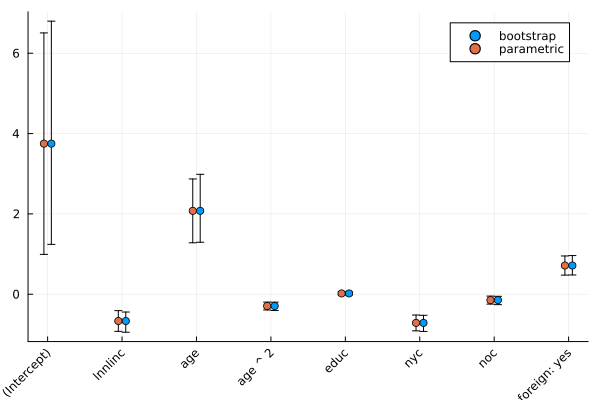

In [44]:
scatter(0.05 .+ (1:8), conf_boot_t.estimate,
        yerror=(conf_boot_t."boot lo", conf_boot_t."boot hi"),
        label="bootstrap",
        xticks=(1:8, conf_boot_t.statistic), xrotation=45)
scatter!(-0.05 .+ (1:8), conf_boot_t.estimate,
         yerror=(conf_boot_t."parametric lo", conf_boot_t."parametric hi"),
         label="parametric")

As you can see both types of intervals are quite close in this case.

Before we finish let us get a sample of how the same task could have been done using the Bootstrap.jl package.

This time the function compiting the statistics does not have to perform sampling as this is handled by the Bootstrap.jl package:

In [45]:
function boot_probit(df_boot)
    probit_boot = glm(@formula(lfp ~ lnnlinc + age + age^2 + educ + nyc + noc + foreign),
                      df_boot, Binomial(), ProbitLink())
    return (; (Symbol.(coefnames(probit_boot)) .=> coef(probit_boot))...)
end

boot_probit (generic function with 1 method)

First we create a bootstrap sample:

In [46]:
Random.seed!(1234)
bs = bootstrap(boot_probit, df, BasicSampling(1000))

Bootstrap Sampling
  Estimates:
     Var │ Estimate    Bias         StdError
         │ Float64     Float64      Float64
    ─────┼────────────────────────────────────
       1 │  3.74896     0.140457    1.40631
       2 │ -0.666932   -0.0153319   0.129736
       3 │  2.07531     0.0181637   0.425717
       4 │ -0.294345   -0.00301596  0.0527653
       5 │  0.0191963   0.00079884  0.0181964
       6 │ -0.714465   -0.0113149   0.103201
       7 │ -0.146985   -0.00136068  0.0522856
       8 │  0.71438     0.00181945  0.12334
  Sampling: BasicSampling
  Samples:  1000
  Data:     DataFrame: { 872 × 8 }


and next we compute 95% percentile confidence intervals:

In [47]:
bs_ci = confint(bs, PercentileConfInt(0.95))

((3.7489556492270126, 1.2412907300091875, 6.798729981241089), (-0.6669318467301517, -0.94728253548464, -0.44317073236838866), (2.0753100253099714, 1.2933397235684985, 2.9847762345144604), (-0.29434520313638074, -0.4053753283179081, -0.1981796050182594), (0.01919626008510484, -0.01585397748961644, 0.0565269367203404), (-0.714464748168672, -0.9267794739575893, -0.5250296490239629), (-0.14698450450783618, -0.25949386579672606, -0.05253327657352294), (0.7143798526957524, 0.4788791797099515, 0.9616215302542082))

Let us chceck if the result matches our manual invervals. First create a new column in our data frame containing tuples. This is a typical example of *nested* data structure, that is handled by DataFrames.jl without any problems.

Notice that I compute the deviations of lower and upper ends of confidence intervals from the estimate to match our earlier computations.

In [48]:
conf_boot_t.bootstrap = [(ci[1], ci[1] - ci[2], ci[3] - ci[1]) for ci in bs_ci]

8-element Vector{Tuple{Float64, Float64, Float64}}:
 (3.7489556492270126, 2.507664919217825, 3.0497743320140764)
 (-0.6669318467301517, 0.2803506887544883, 0.22376111436176305)
 (2.0753100253099714, 0.781970301741473, 0.909466209204489)
 (-0.29434520313638074, 0.11103012518152738, 0.09616559811812134)
 (0.01919626008510484, 0.03505023757472128, 0.03733067663523556)
 (-0.714464748168672, 0.2123147257889173, 0.18943509914470913)
 (-0.14698450450783618, 0.11250936128888989, 0.09445122793431324)
 (0.7143798526957524, 0.23550067298580096, 0.24724167755845572)

We could have inspected our data frame now:

In [49]:
conf_boot_t

Row,statistic,estimate,boot lo,boot hi,parametric lo,parametric hi,bootstrap
,String,Float64,Float64,Float64,Float64,Float64,Tuple…
1,(Intercept),3.74896,2.50766,3.04977,2.75695,2.75695,"(3.74896, 2.50766, 3.04977)"
2,lnnlinc,-0.666932,0.280351,0.223761,0.258558,0.258558,"(-0.666932, 0.280351, 0.223761)"
3,age,2.07531,0.78197,0.909466,0.794584,0.794584,"(2.07531, 0.78197, 0.909466)"
4,age ^ 2,-0.294345,0.11103,0.0961656,0.0978895,0.0978895,"(-0.294345, 0.11103, 0.0961656)"
5,educ,0.0191963,0.0350502,0.0373307,0.0351333,0.0351333,"(0.0191963, 0.0350502, 0.0373307)"
6,nyc,-0.714465,0.212315,0.189435,0.196774,0.196774,"(-0.714465, 0.212315, 0.189435)"
7,noc,-0.146985,0.112509,0.0944512,0.0997336,0.0997336,"(-0.146985, 0.112509, 0.0944512)"
8,foreign: yes,0.71438,0.235501,0.247242,0.23779,0.23779,"(0.71438, 0.235501, 0.247242)"


But it is a bit inconvenient.

First un-nest the `:bootstrap` column into three columns:

In [50]:
select!(conf_boot_t, Not(:bootstrap), :bootstrap => ["estimate 2", "boot lo 2", "boot hi 2"])

Row,statistic,estimate,boot lo,boot hi,parametric lo,parametric hi,estimate 2,boot lo 2,boot hi 2
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,(Intercept),3.74896,2.50766,3.04977,2.75695,2.75695,3.74896,2.50766,3.04977
2,lnnlinc,-0.666932,0.280351,0.223761,0.258558,0.258558,-0.666932,0.280351,0.223761
3,age,2.07531,0.78197,0.909466,0.794584,0.794584,2.07531,0.78197,0.909466
4,age ^ 2,-0.294345,0.11103,0.0961656,0.0978895,0.0978895,-0.294345,0.11103,0.0961656
5,educ,0.0191963,0.0350502,0.0373307,0.0351333,0.0351333,0.0191963,0.0350502,0.0373307
6,nyc,-0.714465,0.212315,0.189435,0.196774,0.196774,-0.714465,0.212315,0.189435
7,noc,-0.146985,0.112509,0.0944512,0.0997336,0.0997336,-0.146985,0.112509,0.0944512
8,foreign: yes,0.71438,0.235501,0.247242,0.23779,0.23779,0.71438,0.235501,0.247242


Next reorder the columns using regular expressions.

In [51]:
select(conf_boot_t, :statistic, r"estimate", r"lo", r"hi")

Row,statistic,estimate,estimate 2,boot lo,parametric lo,boot lo 2,boot hi,parametric hi,boot hi 2
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,(Intercept),3.74896,3.74896,2.50766,2.75695,2.50766,3.04977,2.75695,3.04977
2,lnnlinc,-0.666932,-0.666932,0.280351,0.258558,0.280351,0.223761,0.258558,0.223761
3,age,2.07531,2.07531,0.78197,0.794584,0.78197,0.909466,0.794584,0.909466
4,age ^ 2,-0.294345,-0.294345,0.11103,0.0978895,0.11103,0.0961656,0.0978895,0.0961656
5,educ,0.0191963,0.0191963,0.0350502,0.0351333,0.0350502,0.0373307,0.0351333,0.0373307
6,nyc,-0.714465,-0.714465,0.212315,0.196774,0.212315,0.189435,0.196774,0.189435
7,noc,-0.146985,-0.146985,0.112509,0.0997336,0.112509,0.0944512,0.0997336,0.0944512
8,foreign: yes,0.71438,0.71438,0.235501,0.23779,0.235501,0.247242,0.23779,0.247242


More discussion of various column selectors supported can be found [here](https://bkamins.github.io/julialang/2021/02/06/colsel.html).

Now we can more easily see that our manual computations produce exactly the same results as the Bootstrap.jl package.

Before we finish sort our data frame by the `:estimate`:

In [52]:
sort(conf_boot_t, :estimate)

Row,statistic,estimate,boot lo,boot hi,parametric lo,parametric hi,estimate 2,boot lo 2,boot hi 2
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,nyc,-0.714465,0.212315,0.189435,0.196774,0.196774,-0.714465,0.212315,0.189435
2,lnnlinc,-0.666932,0.280351,0.223761,0.258558,0.258558,-0.666932,0.280351,0.223761
3,age ^ 2,-0.294345,0.11103,0.0961656,0.0978895,0.0978895,-0.294345,0.11103,0.0961656
4,noc,-0.146985,0.112509,0.0944512,0.0997336,0.0997336,-0.146985,0.112509,0.0944512
5,educ,0.0191963,0.0350502,0.0373307,0.0351333,0.0351333,0.0191963,0.0350502,0.0373307
6,foreign: yes,0.71438,0.235501,0.247242,0.23779,0.23779,0.71438,0.235501,0.247242
7,age,2.07531,0.78197,0.909466,0.794584,0.794584,2.07531,0.78197,0.909466
8,(Intercept),3.74896,2.50766,3.04977,2.75695,2.75695,3.74896,2.50766,3.04977


Here is some more advanced example, where we sort the rows by the width of the confidence interval:

In [53]:
conf_boot_t[sortperm(conf_boot_t."boot hi" - conf_boot_t."boot lo"), :]

Row,statistic,estimate,boot lo,boot hi,parametric lo,parametric hi,estimate 2,boot lo 2,boot hi 2
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,lnnlinc,-0.666932,0.280351,0.223761,0.258558,0.258558,-0.666932,0.280351,0.223761
2,nyc,-0.714465,0.212315,0.189435,0.196774,0.196774,-0.714465,0.212315,0.189435
3,noc,-0.146985,0.112509,0.0944512,0.0997336,0.0997336,-0.146985,0.112509,0.0944512
4,age ^ 2,-0.294345,0.11103,0.0961656,0.0978895,0.0978895,-0.294345,0.11103,0.0961656
5,educ,0.0191963,0.0350502,0.0373307,0.0351333,0.0351333,0.0191963,0.0350502,0.0373307
6,foreign: yes,0.71438,0.235501,0.247242,0.23779,0.23779,0.71438,0.235501,0.247242
7,age,2.07531,0.78197,0.909466,0.794584,0.794584,2.07531,0.78197,0.909466
8,(Intercept),3.74896,2.50766,3.04977,2.75695,2.75695,3.74896,2.50766,3.04977


More examples of sorting data frames can be found [here](https://bkamins.github.io/julialang/2021/03/12/sorting.html).